# Q1

Original image shape: torch.Size([6, 6])
Image: tensor([[0.1734, 0.4451, 0.2819, 0.5288, 0.2406, 0.9962],
        [0.4183, 0.0142, 0.8532, 0.2194, 0.3262, 0.1891],
        [0.7867, 0.4064, 0.7342, 0.8929, 0.1758, 0.8562],
        [0.7419, 0.7787, 0.7069, 0.0840, 0.3147, 0.3764],
        [0.3671, 0.9299, 0.9150, 0.0329, 0.7067, 0.8392],
        [0.8069, 0.4779, 0.6557, 0.9849, 0.3681, 0.3382]])
Image shape after unsqueeze (batch dimension): torch.Size([1, 6, 6])
Image shape after adding channel dimension: torch.Size([1, 1, 6, 6])
Kernel shape: torch.Size([3, 3])
Kernel: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Kernel shape after unsqueeze (batch and channel): torch.Size([1, 1, 3, 3])
Output image shape after convolution: torch.Size([1, 1, 4, 4])


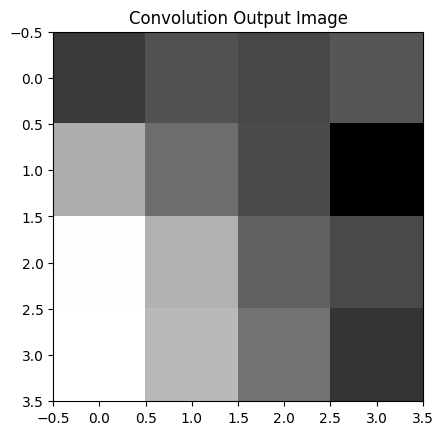

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Create a random image with shape (6, 6)
image = torch.rand(6, 6)
print("Original image shape:", image.shape)
print("Image:", image)

# Add a new dimension along the 0th dimension (for batch size), so shape becomes (1, 6, 6)
image = image.unsqueeze(dim=0)
print("Image shape after unsqueeze (batch dimension):", image.shape)

# Add another dimension along the 1st dimension (for channels), so shape becomes (1, 1, 6, 6)
image = image.unsqueeze(dim=0)
print("Image shape after adding channel dimension:", image.shape)

# Create a random kernel of size (3, 3)
kernel = torch.ones(3, 3)
print("Kernel shape:", kernel.shape)
print("Kernel:", kernel)

# Add batch and channel dimensions to the kernel (shape will be (1, 1, 3, 3))
kernel = kernel.unsqueeze(dim=0).unsqueeze(dim=0)
print("Kernel shape after unsqueeze (batch and channel):", kernel.shape)

# Perform the convolution operation (with stride=1 and padding=0)
outimage = F.conv2d(image, kernel, stride=1, padding=0)
print("Output image shape after convolution:", outimage.shape)

# Display the output image
plt.imshow(outimage.squeeze().detach(), cmap='gray')
plt.title("Convolution Output Image")
plt.show()


# Q2

Output shape from nn.Conv2d: torch.Size([1, 3, 4, 4])
Kernel shape for equivalent conv2d: torch.Size([3, 1, 3, 3])
Output shape from functional conv2d: torch.Size([1, 3, 4, 4])


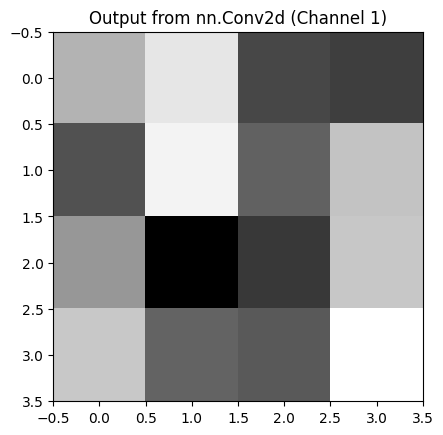

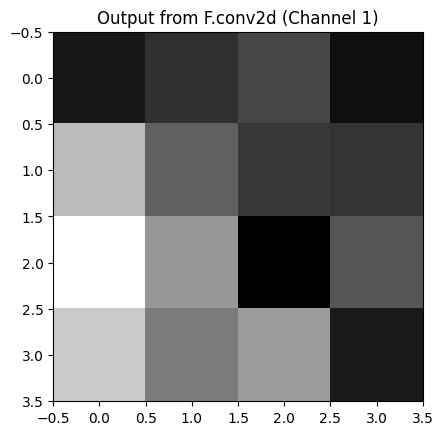

In [10]:
# Apply nn.Conv2d with output channel=3
conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0)
output_conv2d = conv_layer(image)
print("Output shape from nn.Conv2d:", output_conv2d.shape)

# Now, let's implement the equivalent using F.conv2d to get the same output (ignoring bias)
# Create a random kernel of size (3, 3) for 3 output channels
kernel_conv = torch.rand(3, 1, 3, 3)  # 3 output channels, 1 input channel
print("Kernel shape for equivalent conv2d:", kernel_conv.shape)

# Apply convolution using F.conv2d
output_func_conv2d = F.conv2d(image, kernel_conv, stride=1, padding=0)
print("Output shape from functional conv2d:", output_func_conv2d.shape)

# Display the output from nn.Conv2d
plt.imshow(output_conv2d.squeeze(0).detach()[0], cmap='gray')
plt.title("Output from nn.Conv2d (Channel 1)")
plt.show()

# Display the output from functional conv2d
plt.imshow(output_func_conv2d.squeeze(0).detach()[0], cmap='gray')
plt.title("Output from F.conv2d (Channel 1)")
plt.show()


# Q3

Accuracy: 98.89%


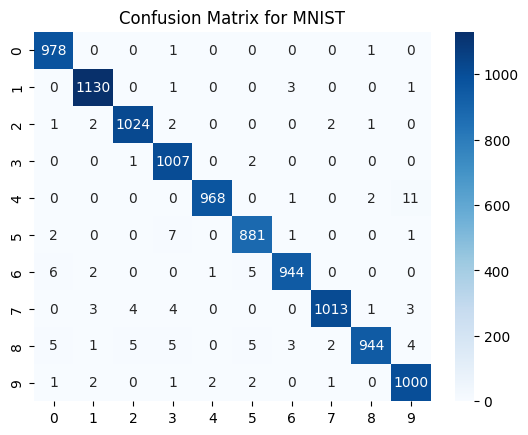

Number of learnable parameters in the model: 421642


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define CNN Model Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST digits

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64*7*7)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the CNN Model, Loss Function, and Optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 3  # You can change this for more epochs
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the Model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = np.mean(np.array(y_pred) == np.array(y_true))
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for MNIST")
plt.show()

# Number of Learnable Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of learnable parameters in the model: {num_params}')


# Q4

In [17]:
# Smaller CNN Architecture
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32*7*7, 64)
        self.fc2 = nn.Linear(64, 10)  # 10 classes for MNIST digits

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 32*7*7)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

# Initialize the smaller model and check number of parameters
small_model = SmallCNN()
num_params_small = sum(p.numel() for p in small_model.parameters() if p.requires_grad)
print(f'Number of learnable parameters in smaller CNN: {num_params_small}')


Number of learnable parameters in smaller CNN: 105866


## practice

Accuracy: 96.77%


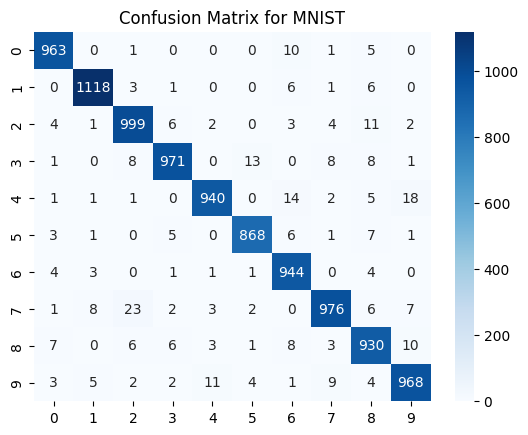

Number of learnable parameters in the model: 51522


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define CNN Model Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16*7*7, 64)
        self.fc2 = nn.Linear(64, 10)  # 10 classes for MNIST digits

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*7*7)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the CNN Model, Loss Function, and Optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1  # You can change this for more epochs
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the Model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = np.mean(np.array(y_pred) == np.array(y_true))
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for MNIST")
plt.show()

# Number of Learnable Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of learnable parameters in the model: {num_params}')


# Additional Question

Epoch 1, Loss: 0.4412461273324515
Epoch 2, Loss: 0.27959715467748614
Epoch 3, Loss: 0.23687104503117773
Epoch 4, Loss: 0.20755879495586796
Epoch 5, Loss: 0.18098725905931834


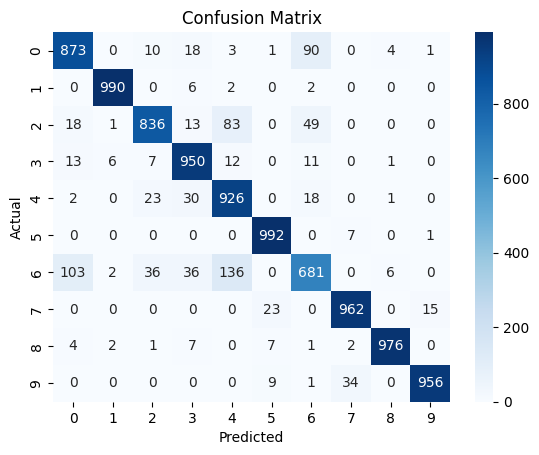

Total Parameters: 421642


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Define CNN model (same as before)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Evaluate the model
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate learnable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {count_parameters(model)}")
